In [33]:
# instalar as bibliotecas necessárias
#!pip install numpy pandas matplotlib scikit-learn tabletext scipy seaborn

## Determinar a quantidade de Cluster para o algorítmo K-means

In [34]:
# importar bibliotecas
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import scipy.stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from IPython.display import display,HTML

In [35]:
#configurar tema dos gráficos
sns.set_theme()

In [36]:
def avaliar_opcoes_arranjo(qtd_min_clusters,qtd_max_clusters,dataset):
    # Definir range de clusters
    range_clusters = range(qtd_min_clusters,qtd_max_clusters+1)
    
    # Lista para armazenar os resultados da clusterização para cada arranjo
    resultados=[]
    
    for i,k in enumerate(range_clusters):
        resultado={"arranjo":f"{k} Grupos","qtd_grupos":k }
        
        #print("="*24)
        #print(f"Calculando K-Means para {k } clusters")
        #print("_"*24)
        # Criar um objeto KMeans
        kmeans = KMeans(n_clusters=k)
        
        # Treinar o modelo
        kmeans.fit(dataset)
        # Obter os rótulos dos clusters para cada ponto de dados
        rotulos = kmeans.labels_
        centroides = kmeans.cluster_centers_
        
        resumo_classificacao=[]
        qtd_por_grupos=pd.DataFrame(rotulos).groupby(0)[0].count()
        
        for i,qtd in enumerate(qtd_por_grupos):
            resumo_classificacao.append({"grupo":i+1,"qtd":qtd,"silhueta":0})
    
        # Calcular a silhueta para cada amostra
        silhuetas = silhouette_samples(dados, rotulos)
        
        # Calcular a média da silhueta
        silhueta_media = silhouette_score(dados, rotulos)
        resultado["silhueta_media"]=silhueta_media
    
        
        # Calcular a média da silhueta para cada grupo
        for i in np.unique(rotulos):
            resumo_classificacao[i]["silhueta"]=np.mean(silhuetas[rotulos == i])
            resumo_classificacao[i]["centroides"]=centroides[i]
    
        resultado["resumo_classificacao"]=resumo_classificacao
        resultado["rotulos"]=rotulos
        resultado["silhuetas"]=silhuetas
        resultado["centroides"]=centroides
        #print(resultado)
        
        resultados.append(resultado)
    return resultados

In [37]:
def obter_resultados_validos(resultados,silhueta_corte=0.50):
    # Avaliar resultados de clusterização para cada arranjo
    resultados_validos=[]
    for res in resultados:
        if res["silhueta_media"] >silhueta_corte:
            res["e_valido"]=True
            for grupo in res["resumo_classificacao"]:
                if grupo["silhueta"]<silhueta_corte: # largura da silhueta do grupo
                    res["e_valido"]=False
                    pass
            
            resultados_validos.append(res)
    
    return resultados_validos

In [38]:
def calcular_entropia_1(valores_variavel):
    soma_valores = np.sum(valores_variavel)
    qtd_valores=len(valores_variavel)
    ln = np.log(qtd_valores)
    entropia = (-1/ln)*soma_valores
    #print(soma_valores,qtd_valores,ln,entropia,1-entropia)
    return 1-entropia

In [39]:
def calcular_entropia(valores_variavel):
    unique_values, value_counts = np.unique(valores_variavel, return_counts=True)
    value_probs = value_counts / len(valores_variavel)
    entropy = -np.sum(value_probs * np.log2(value_probs + 1e-10))  # Adicionando um pequeno valor para evitar log(0)
    return entropy

In [40]:
def selecionar_melhor_opcao_arranjo(resultados_validos):
    if len(resultados_validos)==0:
        return None
        
    arranjo_selecionado=None
    todos_arranjos_validos=False
    
    menor_grupo = resultados_validos[0]["qtd_grupos"]
    maior_silhueta=resultados_validos[0]["silhueta_media"]
    
    indice_menor_grupo=0
    indice_maior_silhueta=0
    
    for i,res in enumerate(resultados_validos):
        if menor_grupo > res["qtd_grupos"]:
            menor_grupo=res["qtd_grupos"]
            indice_menor_grupo=i
            print(menor_grupo ,res["qtd_grupos"])
            
        if maior_silhueta < res["silhueta_media"]:
            maior_silhueta=res["silhueta_media"]
            indice_maior_silhueta=i
            print(maior_silhueta ,res["silhueta_media"])
    
    if todos_arranjos_validos:
        arranjo_selecionado= resultados_validos[indice_menor_grupo]
    else:
        arranjo_selecionado= resultados_validos[indice_maior_silhueta]
    
    return arranjo_selecionado

In [41]:
def imprimir_dados_arranjo(arranjo):
   
    display(HTML(
    f'''
    <h4> Detalhes do Arranjo</h4>
    <hr>
    <ul>
        <li><b>Arranjo selecionado</b>: {arranjo["arranjo"]}</li>
        <li><b>Qtd. Grupos</b>: {arranjo["qtd_grupos"]}</li>
        <li><b>Silhueta média</b>: {arranjo["silhueta_media"]:.4f}</li>
    </ul>
    <br/>
    <table>
        <tr><th>No.</th><th>Qtd. Registros</th><th>Silhueta</th></tr>
        {   
            '</tr><tr>'.join(
            '<td>{}</td><td>{}</td><td>{}</td>'.format(grupo["grupo"],grupo["qtd"],grupo["silhueta"])
            for grupo in arranjo["resumo_classificacao"])
                
        }
    </table>
    '''
))

In [42]:
def imprimir_grafico_analise_arranjo(arranjo):
    cluster =arranjo
    
    print(
        "For n_clusters =",
        cluster["qtd_grupos"],
        "The average silhouette_score is :",
        cluster["silhueta_media"],
    )
    
    # Criar um gráfico com 1 linha e 2 colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Gráfico para exibir a silhueta
    # Definir os limites
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dfArquivo) + (cluster["qtd_grupos"] + 1) * 10])
    
    y_lower = 10
    
    for i in range(cluster["qtd_grupos"]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = cluster["silhuetas"][cluster["rotulos"] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / cluster["qtd_grupos"])
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=cluster["silhueta_media"], color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster["rotulos"].astype(float) / cluster["qtd_grupos"])
    ax2.scatter(
        dfArquivo.iloc[:, 1], dfArquivo.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = cluster["centroides"]
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        %cluster["qtd_grupos"],
        fontsize=14,
        fontweight="bold",
    )
    
    plt.show()

In [43]:
# abrir dataset com os indicadores
PATH_TO_DATASET="../dataset/dados_k_means_3.csv"
dfArquivo=pd.read_csv(PATH_TO_DATASET,sep=";")
dfArquivo.describe()

,Census tract,EN1,DM1,DM2,DM3,DM4,EC1,EC2,EC3,ED1,ED2,HS1,HS2,HS3,HS4,HS5,EN1.1
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,4.116900e+14,0.296014,0.418543,0.919942,0.612828,0.636569,0.811266,0.045010,0.555011,0.930897,0.816855,0.986195,0.059185,0.674922,0.937378,0.546460,0.389294
std,3.831491e+11,0.061245,0.104599,0.125474,0.098168,0.131548,0.157044,0.107741,0.187450,0.117805,0.152264,0.071940,0.126400,0.409789,0.174557,0.145992,0.145132
min,4.115200e+14,0.131733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.115200e+14,0.257018,0.352727,0.918513,0.563647,0.552469,0.753375,0.000000,0.415021,0.882971,0.734800,1.000000,0.004134,0.114850,0.989604,0.462410,0.296886
50%,4.115200e+14,0.291355,0.403636,0.959388,0.608936,0.638889,0.863186,0.000000,0.522037,1.000000,0.847200,1.000000,0.015019,0.941700,1.000000,0.564600,0.378254
75%,4.115200e+14,0.331523,0.465455,0.983914,0.659355,0.725309,0.917079,0.029186,0.698337,1.000000,0.932800,1.000000,0.047081,0.985300,1.000000,0.642955,0.473441
max,4.126256e+14,0.553729,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Avaliar classificação com as sugestões de quantidade ótima de grupos sugerida pelos métodos de avaliação

For n_clusters = 2 The average silhouette_score is : 0.5779557502653339


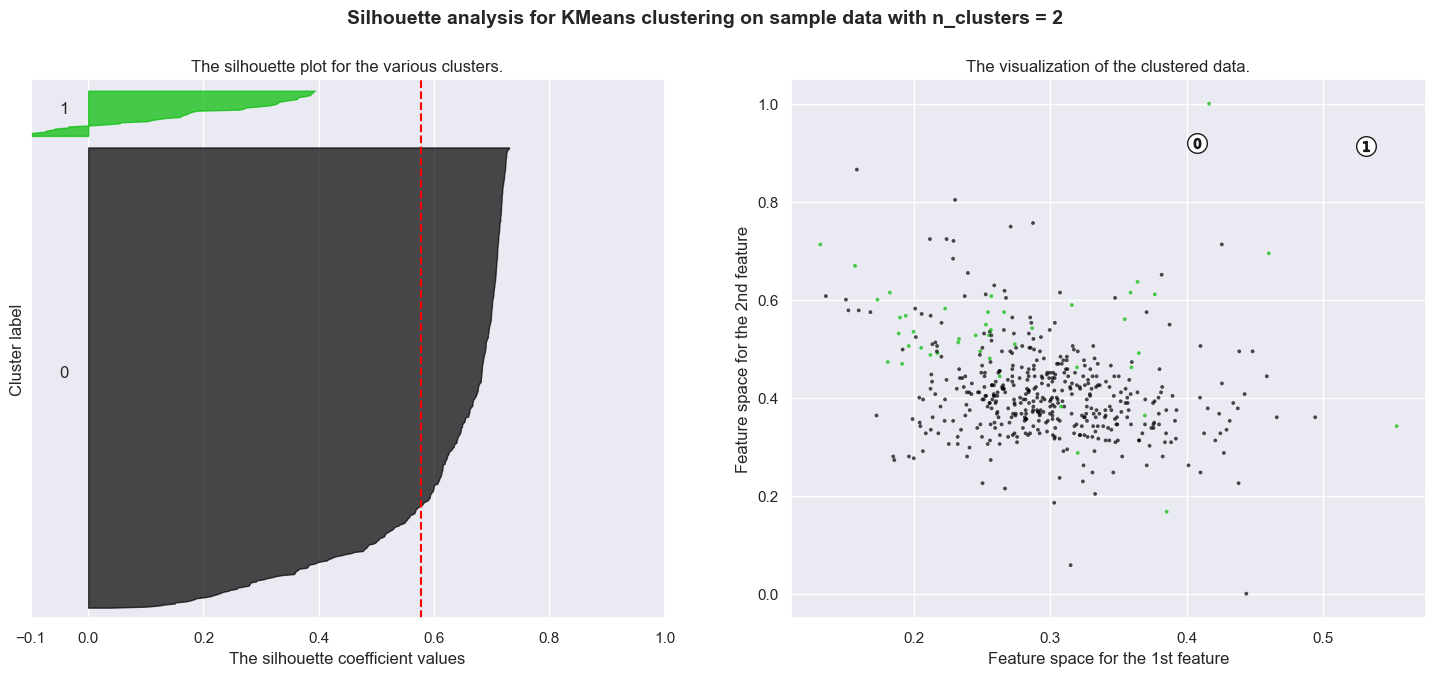

For n_clusters = 13 The average silhouette_score is : 0.26109032740526916


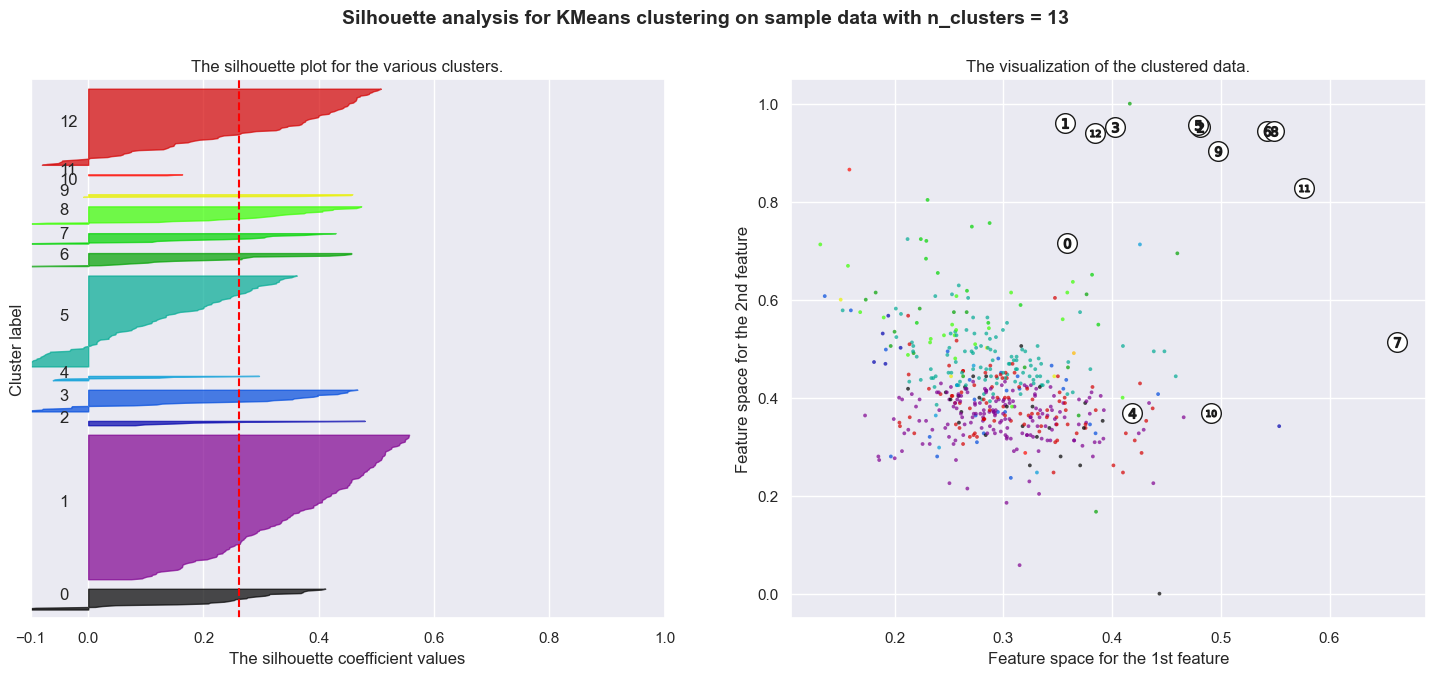

For n_clusters = 14 The average silhouette_score is : 0.24461282312118413


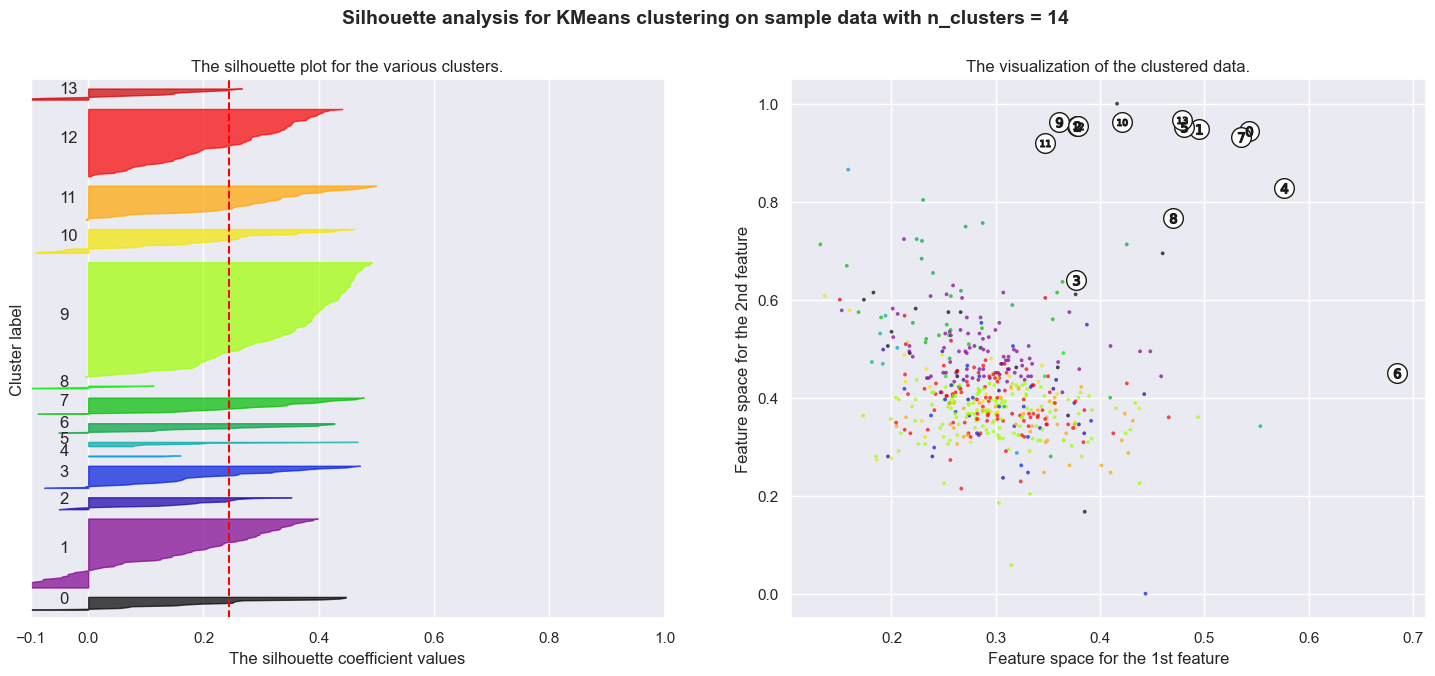

In [46]:
# Obter classificação com a quantidade de clusters sugerida pelos métodos seleção
sugestoes_clusters=[2,13,14]
for k in sugestoes_clusters:
    classificacao=avaliar_opcoes_arranjo(k,k,dados)
    imprimir_grafico_analise_arranjo(classificacao[0])

In [12]:
# definir o range de clusters que serão avaliados
QTD_MIN_CLUSTERS=3
QTD_MAX_CLUSTERS=7

# Gerar dados sintéticos para classificação
# X=pd.DataFrame( np.random.rand(10000, 9))

# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)

# Resultado da avaliação 
resultados_pre_otimizacao= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
resultados_validos=obter_resultados_validos(resultados_pre_otimizacao)

resultados_validos

[]

For n_clusters = 3 The average silhouette_score is : 0.2984652584272595


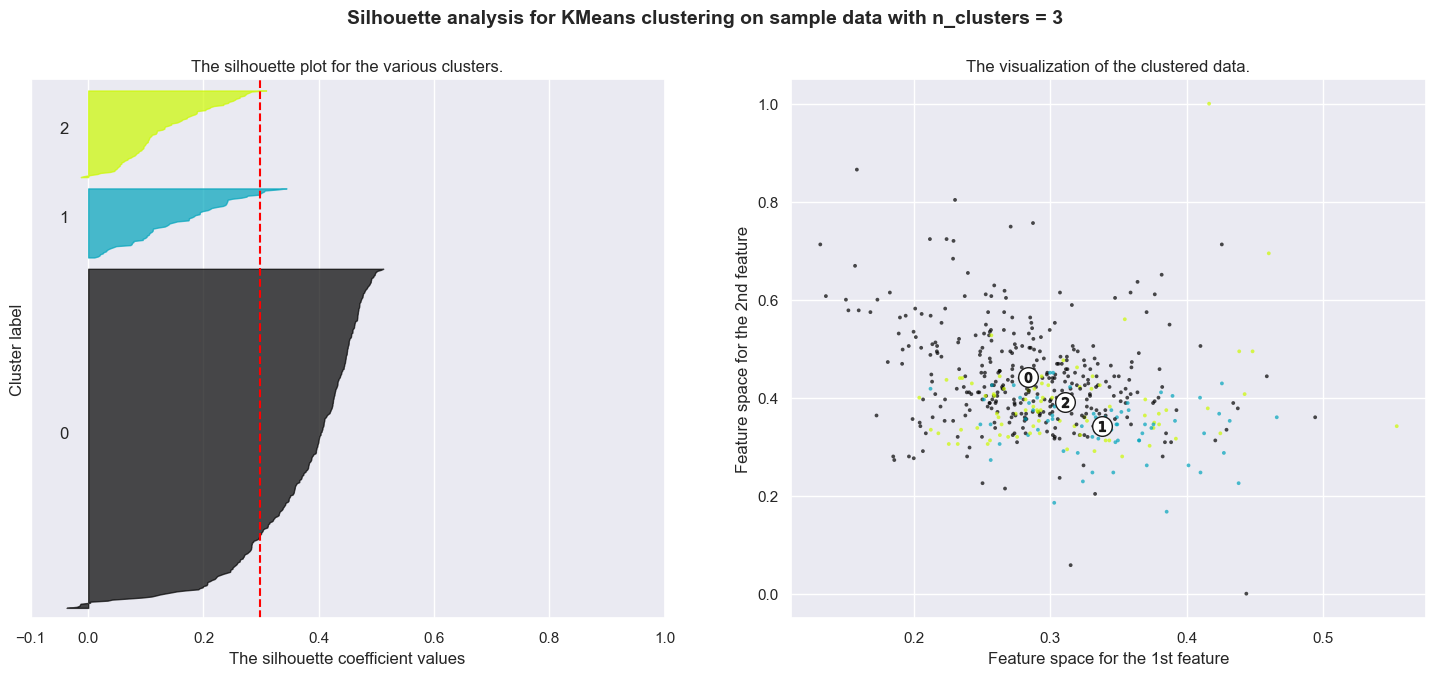

For n_clusters = 4 The average silhouette_score is : 0.30617164210065423


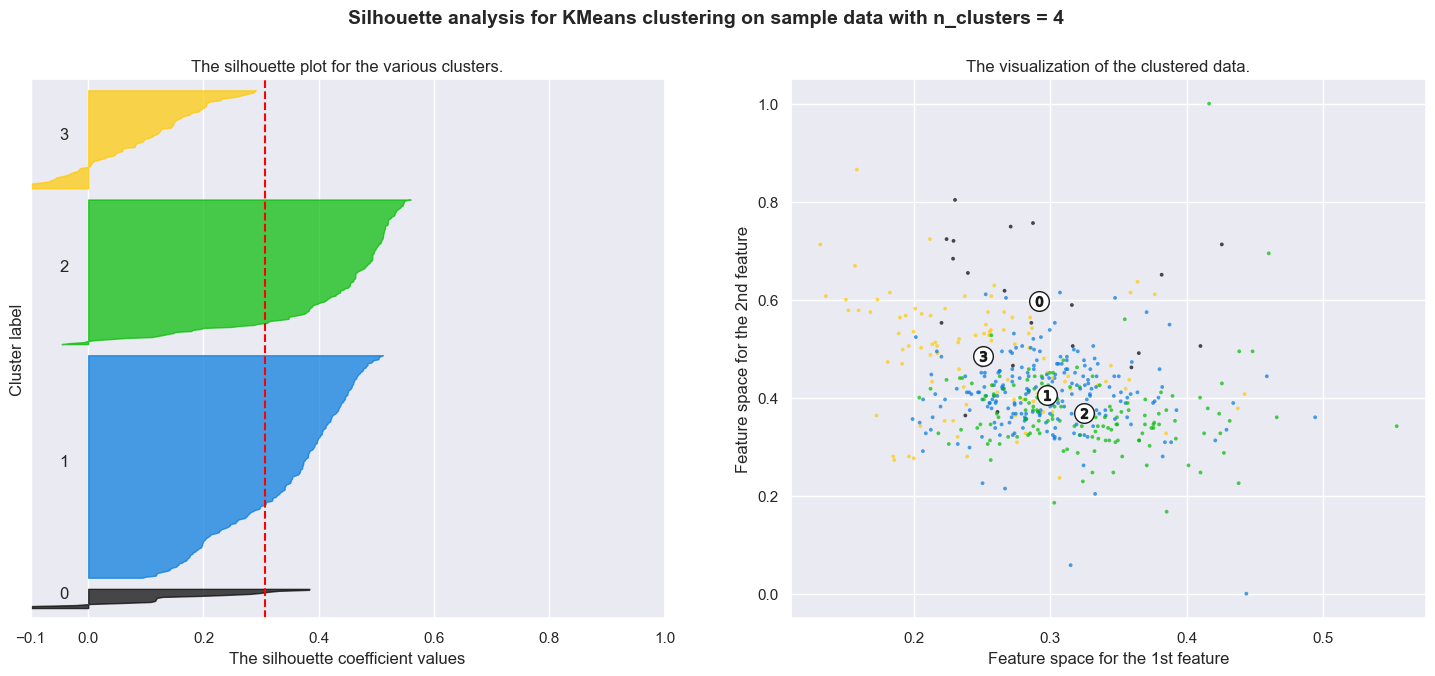

For n_clusters = 5 The average silhouette_score is : 0.25898212890197697


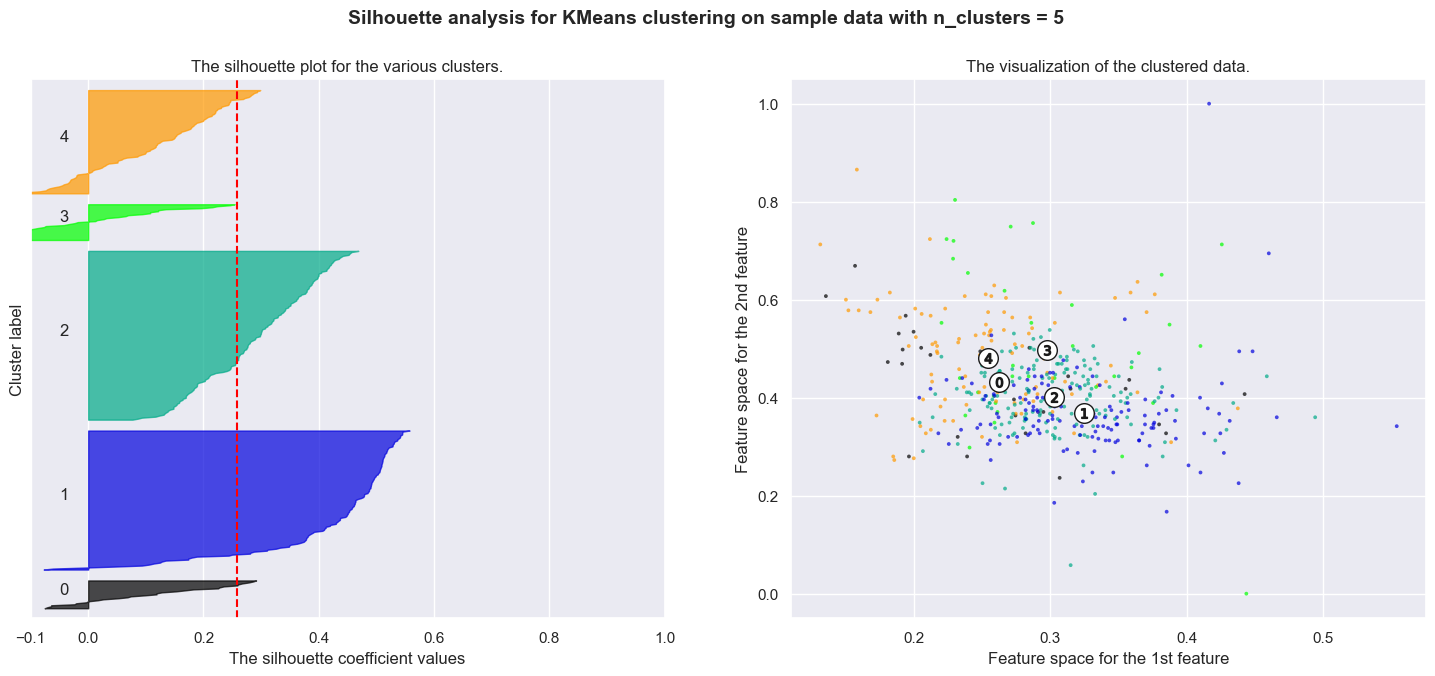

For n_clusters = 6 The average silhouette_score is : 0.15928075694173338


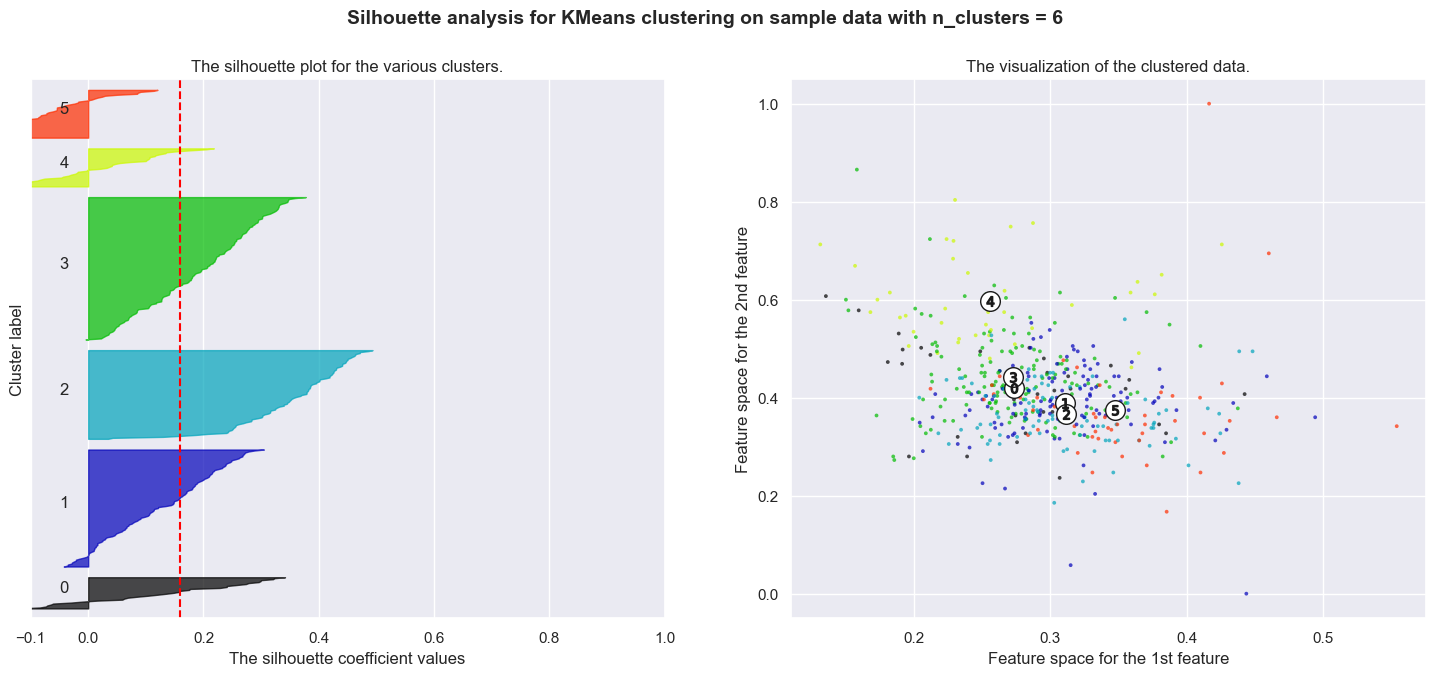

For n_clusters = 7 The average silhouette_score is : 0.160373809367256


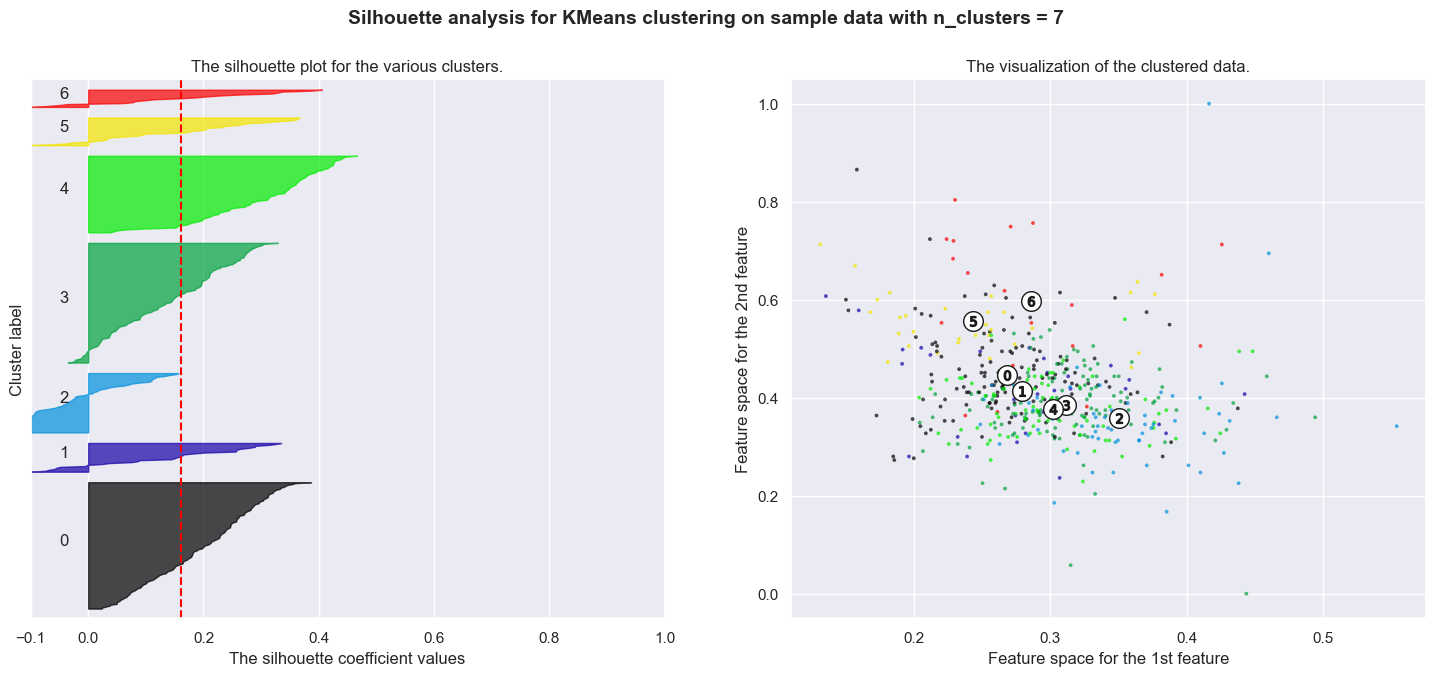

In [13]:
for arranjo in resultados_pre_otimizacao:
    imprimir_grafico_analise_arranjo(arranjo)
    

In [14]:
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
entropias = []

for col in range(dados.shape[1]):
    entropias.append({"variavel":dados.columns[col],"entropia":calcular_entropia(dados.iloc[:,col])})

dfEntropias = pd.DataFrame(entropias)
dfEntropias.sort_values(by=["entropia"],ascending=False,inplace=True)
dfEntropias

,variavel,entropia
0,EN1,8.915879
15,EN1.1,8.915879
7,EC3,8.820641
14,HS5,8.749700
3,DM3,8.694307
5,EC1,8.571906
9,ED2,8.274006
12,HS3,8.160091
4,DM4,7.035503
11,HS2,6.798749


In [15]:
# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["Census tract"],axis=1)
resultados_validos=[]

melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

i_entropia=0
iteracao=1

sumario_iteracoes=[]

while melhor_arranjo is None:
    qtd_variaveis=dados.shape[1]
    if qtd_variaveis < 3:
        print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Dataset após a exclusão das variáveis não encontrou um resultado.")
        break
        
    #print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Analisar a entropia das variáveis.")
    
    menor_entropia=dfEntropias.iloc[i_entropia]
    #print(f"Excluir a variável '{menor_entropia['variavel']}' do dataset ")
    
    # Excluir varíavel com menor entropia
    dados=dados.drop([menor_entropia["variavel"]],axis=1)
    
    # Refazer o K-means utilizando o novo dataset sem a variável com a menor entropia
    resultados= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
    resultados_validos=obter_resultados_validos(resultados)
    
    melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

    dados_iteracao = {"iteracao":iteracao,
     "resultados_validos":len(resultados_validos),
     "variavel_excluida":f'Variável: {menor_entropia["variavel"]} [{menor_entropia["entropia"]}]',}

    sumario_iteracoes.append(dados_iteracao)
    
    i_entropia+=1
    iteracao+=1
    
display(HTML(f'<h3> \o/ Melhor arranjo encontrado após {iteracao-1} iterações!</h3>'))

imprimir_dados_arranjo(melhor_arranjo)

,DM1,DM2,EC2,ED1,HS1,HS2,HS4
0,0.723636,0.923523,0.153226,1.000000,1.000000,0.024468,1.000000
1,0.669091,0.947785,0.291475,1.000000,1.000000,0.257003,0.588340
2,0.607273,0.948840,0.387865,1.000000,1.000000,0.239116,0.833664
3,0.567273,0.962553,0.599078,0.722431,1.000000,0.107661,0.070003
4,0.534545,0.979430,0.361367,1.000000,1.000000,0.086061,0.201024
...,...,...,...,...,...,...,...
478,0.352727,0.974684,0.009217,0.929482,1.000000,0.004050,1.000000
479,0.367273,0.952532,0.000000,0.760690,1.000000,0.000000,0.990597
480,0.360000,0.946730,0.003840,0.888972,0.994001,0.001687,0.980984
481,0.320000,0.621308,0.000000,0.882221,0.982603,0.000000,1.000000


For n_clusters = 3 The average silhouette_score is : 0.5634114439949164


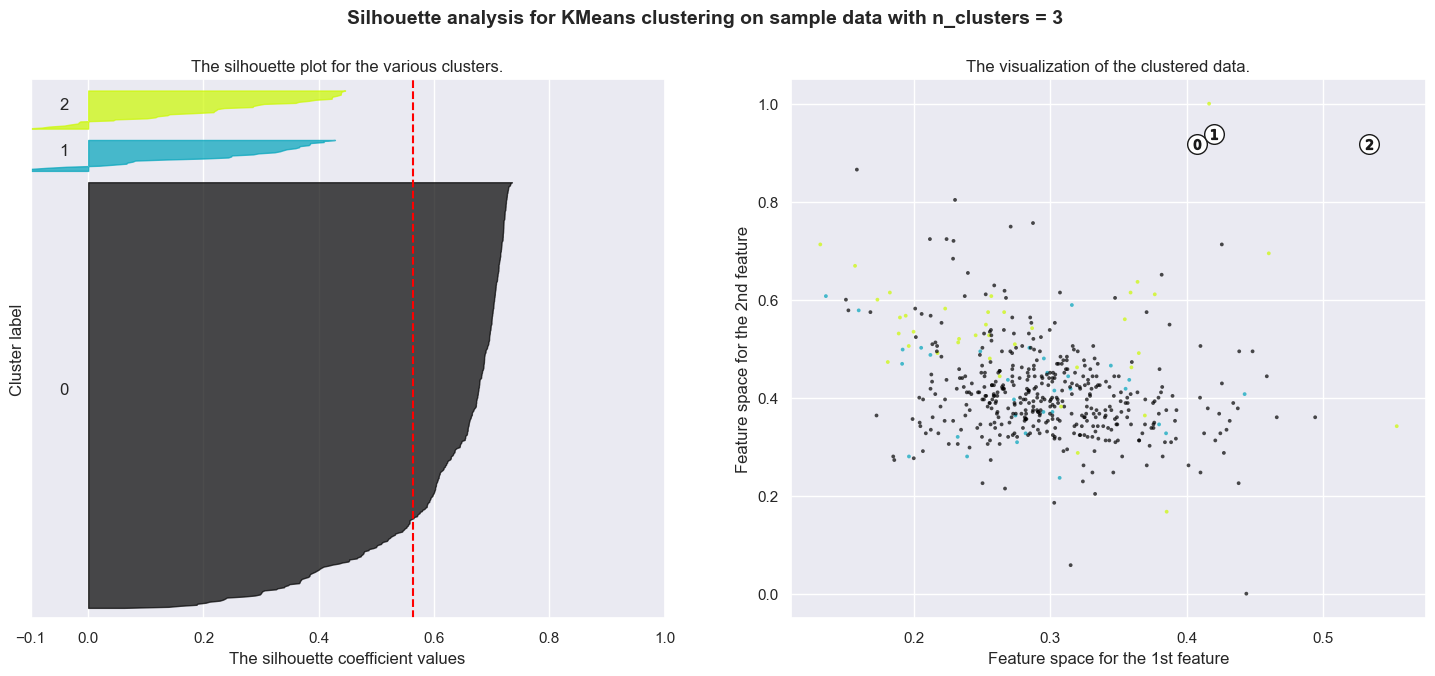

In [17]:
imprimir_grafico_analise_arranjo(melhor_arranjo)

In [18]:
# Ver detalhes das iterações da análise de entropia
pd.DataFrame(sumario_iteracoes)

,iteracao,resultados_validos,variavel_excluida
0,1,0,Variável: EN1 [8.915879309153606]
1,2,0,Variável: EN1.1 [8.915879309153606]
2,3,0,Variável: EC3 [8.820641217233709]
3,4,0,Variável: HS5 [8.749699889300839]
4,5,0,Variável: DM3 [8.694306749349918]
5,6,0,Variável: EC1 [8.571906306253773]
6,7,0,Variável: ED2 [8.2740056810058]
7,8,0,Variável: HS3 [8.16009100739564]
8,9,1,Variável: DM4 [7.035502832980362]


In [25]:
# Variáveis restantes após otimização
dados

,DM1,DM2,EC2,ED1,HS1,HS2,HS4
0,0.723636,0.923523,0.153226,1.000000,1.000000,0.024468,1.000000
1,0.669091,0.947785,0.291475,1.000000,1.000000,0.257003,0.588340
2,0.607273,0.948840,0.387865,1.000000,1.000000,0.239116,0.833664
3,0.567273,0.962553,0.599078,0.722431,1.000000,0.107661,0.070003
4,0.534545,0.979430,0.361367,1.000000,1.000000,0.086061,0.201024
...,...,...,...,...,...,...,...
478,0.352727,0.974684,0.009217,0.929482,1.000000,0.004050,1.000000
479,0.367273,0.952532,0.000000,0.760690,1.000000,0.000000,0.990597
480,0.360000,0.946730,0.003840,0.888972,0.994001,0.001687,0.980984
481,0.320000,0.621308,0.000000,0.882221,0.982603,0.000000,1.000000


In [19]:
# Ver os resultados válidos ao final das análises
[imprimir_dados_arranjo(r) for r in resultados_validos]

[None]

In [20]:
[imprimir_dados_arranjo(r) for r in resultados]

[None, None, None, None, None]

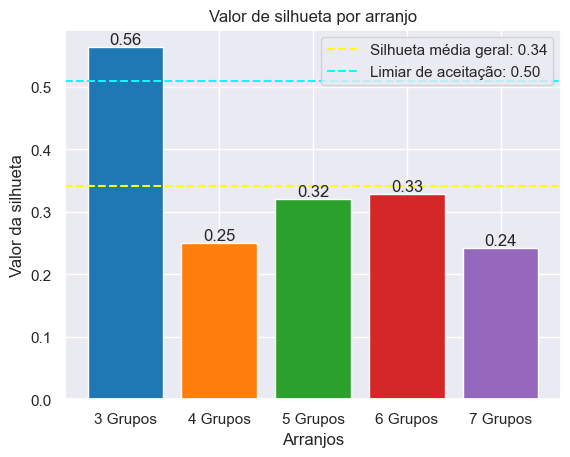

In [21]:

silhuetas=[r["silhueta_media"]for r in resultados]
nomes_arranjo=[r["arranjo"]for r in resultados]

silhueta_media_geral = np.mean(silhuetas)

cores = [a[0] for a in mcolors.TABLEAU_COLORS.items()][:len(nomes_arranjo)]

fig, ax = plt.subplots()
bar_container = ax.bar(nomes_arranjo, silhuetas,color=cores)

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=silhueta_media_geral, color='yellow', linestyle='--', label=f'Silhueta média geral: {silhueta_media_geral:.2f}')

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=0.51, color='cyan', linestyle='--', label=f'Limiar de aceitação: {0.50:.2f}')

# Adicionar legenda para as linhas
ax.legend()

ax.set(ylabel='Valor da silhueta', title='Valor de silhueta por arranjo',xlabel="Arranjos")
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

In [32]:
dfClassificacao=dfArquivo[["Census tract"]]

dfArquivo["Grupo"]=pd.Series(melhor_arranjo["rotulos"])

dfArquivo

,Census tract,EN1,DM1,DM2,DM3,DM4,EC1,EC2,EC3,ED1,ED2,HS1,HS2,HS3,HS4,HS5,EN1.1,Grupo
0,411520005010001,0.211989,0.723636,0.923523,0.568170,0.774691,0.836859,0.153226,0.888877,1.000000,0.9856,1.000000,0.024468,1.0000,1.000000,0.572691,0.190181,0
1,411520005010002,0.157180,0.669091,0.947785,0.659827,0.805556,0.910891,0.291475,0.891996,1.000000,0.9868,1.000000,0.257003,1.0000,0.588340,0.550909,0.060300,2
2,411520005010003,0.135831,0.607273,0.948840,0.617171,0.811728,0.877588,0.387865,0.936590,1.000000,0.9688,1.000000,0.239116,1.0000,0.833664,0.645631,0.009710,1
3,411520005010004,0.194263,0.567273,0.962553,0.571139,0.753086,0.928218,0.599078,0.910499,0.722431,0.9716,1.000000,0.107661,1.0000,0.070003,0.692930,0.148177,2
4,411520005010005,0.200033,0.534545,0.979430,0.689390,0.780864,0.920567,0.361367,0.966112,1.000000,0.9844,1.000000,0.086061,0.9961,0.201024,0.700398,0.161849,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,412625605000066,0.326977,0.352727,0.974684,0.641199,0.608025,0.853285,0.009217,0.331393,0.929482,0.7972,1.000000,0.004050,0.0338,1.000000,0.646378,0.462668,0
479,412625605000067,0.423743,0.367273,0.952532,0.595437,0.595679,0.872412,0.000000,0.319647,0.760690,0.7136,1.000000,0.000000,0.0657,0.990597,0.706497,0.691973,0
480,412625605000068,0.333365,0.360000,0.946730,0.529968,0.574074,0.640414,0.003840,0.385759,0.888972,0.6440,0.994001,0.001687,0.0314,0.980984,0.704630,0.477806,0
481,412625605000069,0.330927,0.320000,0.621308,0.437635,0.293210,0.333933,0.000000,0.442100,0.882221,0.6436,0.982603,0.000000,0.0144,1.000000,0.686706,0.472028,0
